In [1]:
from functions.load_all_data import load_imgs_masks
from functions.sizes import compute_avg_size
from functions.composites import composite_masks
from skimage.transform import rescale, resize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_imgs, mask_colls = load_imgs_masks()[:2]

In [3]:
ex_imgs, ex_masks = all_imgs[:9], mask_colls[:9]

In [4]:
for i in range(len(ex_masks)):
    mask = ex_masks[i]
    ex_masks[i] = composite_masks(mask)

In [5]:
for img in ex_imgs[:2]:
    print(img.shape)

(256, 256, 4)
(520, 696, 4)


In [16]:
sample_img = ex_imgs[1]
sample_mask = ex_masks[1]

curr_size = compute_avg_size(sample_mask)
target_size = curr_size * 2

ratio = curr_size / target_size

617.0992907801418


In [17]:
rescaled = rescale(sample_mask, ratio)

2.1355898257560586


0.5


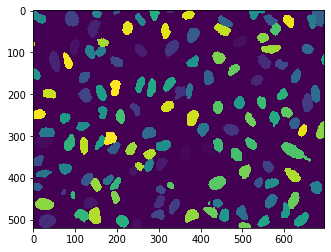

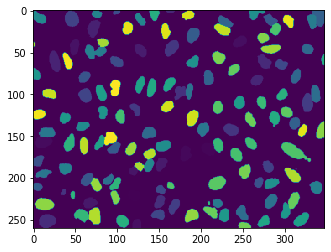

In [8]:
plt.imshow(sample_mask); plt.figure()
plt.imshow(rescaled)
print(ratio)

(260, 348)

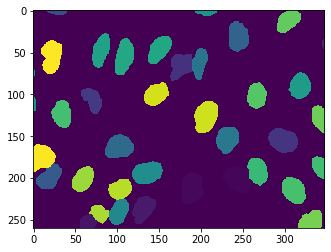

In [27]:
zeros = np.zeros(sample_mask.shape[0:2])
center = (sample_mask.shape[0] * .5, sample_mask.shape[1] * .5)
new_size = (sample_mask.shape[0] * ratio, sample_mask.shape[1] * ratio)

left = max(0, int(center[0] - new_size[0] / 2))
right = min(sample_mask.shape[0], int(center[0] + new_size[0] / 2))
upper = max(0, int(center[1] - new_size[1] / 2))
lower = min(sample_mask.shape[1], int(center[1] + new_size[1] / 2))

cropped_img = sample_mask[left:right, upper:lower]
plt.imshow(cropped_img)
cropped_img.shape

(520, 696)

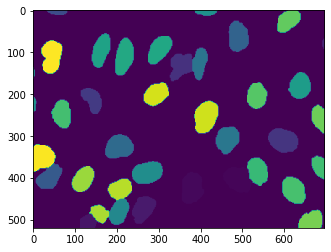

In [32]:
cropped_img = resize(cropped_img, (sample_mask.shape[0:2]))
cropped_img = cropped_img % len(np.unique(cropped_img))
plt.imshow(cropped_img)
cropped_img.shape

In [33]:
cropped_size = compute_avg_size(cropped_img)
print("Original size = %f\nNew size = %f" %(curr_size, cropped_size))

Original size = 617.099291
New size = 19.640903


In [36]:
len(np.unique(cropped_img))

4827